# SHAP Values

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('default')

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from scipy.special import softmax

In [4]:
import shap 

### Functions

In [5]:
def print_feature_importances_random_forest(random_forest_model):
    
    '''
    Prints the feature importances of a Random Forest model in an ordered way.
    random_forest_model -> The sklearn.ensemble.RandomForestRegressor or RandomForestClassifier trained model
    '''
    
    # Fetch the feature importances and feature names
    importances = random_forest_model.feature_importances_
    features = random_forest_model.feature_names_in_
    
    # Organize them in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f}")

In [6]:
def print_feature_importances_shap_values(shap_values, features):
    
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''

    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        
    # Calculates the normalized version
    importances_norm = softmax(importances)

    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}

    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}

    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [7]:
def evaluate_regression(y, y_pred):
    
    '''
    Prints the most common evaluation metrics for regression
    '''
    
    mae = MAE(y, y_pred)
    mse = MSE(y, y_pred)
    rmse = mse ** (1/2)
    r2 = R2(y, y_pred)
    
    print('Regression result')
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")

## Regression

### Import a regression dataset

In [8]:
from sklearn.datasets import fetch_california_housing

In [9]:
dataset = fetch_california_housing(as_frame = True)

In [10]:
print(dataset['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [11]:
# Gets the independent variables
X = dataset['data']
X.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [12]:
# Checks the shape of the data
X.shape

(20640, 8)

In [13]:
# Gets the dependent variable (the target)
y = dataset['target']
y.head(5)

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

### Create a simple regression

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [15]:
# Prepares a default instance of the random forest regressor
model = RandomForestRegressor()

In [16]:
# Fits the model on the data
model.fit(X_train, y_train)

RandomForestRegressor()

In [17]:
# Evaluates the model
y_pred = model.predict(X_test)
evaluate_regression(y_test, y_pred)

Regression result
MAE: 0.32
MSE: 0.25
RMSE: 0.50
R2: 0.81


In [18]:
# Prints the feature importances
print_feature_importances_random_forest(model)

MedInc -> 0.5222
AveOccup -> 0.1402
Latitude -> 0.0913
Longitude -> 0.0883
HouseAge -> 0.0511
AveRooms -> 0.0474
Population -> 0.0301
AveBedrms -> 0.0294


### SHAP values

In [19]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)

In [20]:
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Exact explainer: 4129it [19:03,  3.59it/s]                                                                             


In [21]:
shap_values

.values =
array([[-0.43059695,  0.02837395, -0.03344403, ..., -0.26043147,
         0.25253069, -0.48104843],
       [ 0.40884984,  0.03593051,  0.07879728, ..., -0.20341054,
         0.27026757,  0.01841511],
       [-0.19661881,  0.04131345, -0.02903634, ..., -0.27728297,
         0.38474295, -0.1090663 ],
       ...,
       [-0.39120906,  0.01379426, -0.0104119 , ..., -0.1713356 ,
         0.42328428, -0.69377736],
       [-0.62674149, -0.10521029, -0.08707556, ...,  0.41231172,
         0.47381769, -0.78435834],
       [-0.56572781,  0.02006445, -0.0661148 , ..., -0.10199525,
         0.22900249, -0.72811245]])

.base_values =
array([2.05911461, 2.05911461, 2.05911461, ..., 2.05911461, 2.05911461,
       2.05911461])

.data =
array([[   2.3636    ,   39.        ,    3.99339934, ...,    4.27062706,
          34.06      , -117.63      ],
       [   5.5709    ,   31.        ,    6.72108844, ...,    2.99659864,
          34.21      , -118.63      ],
       [   3.1194    ,   33.        

### SHAP global evaluation

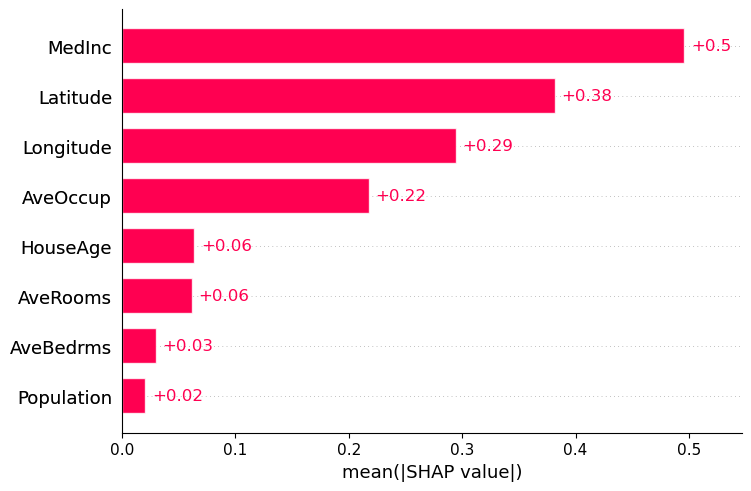

In [23]:
# Plots this view
shap.plots.bar(shap_values)

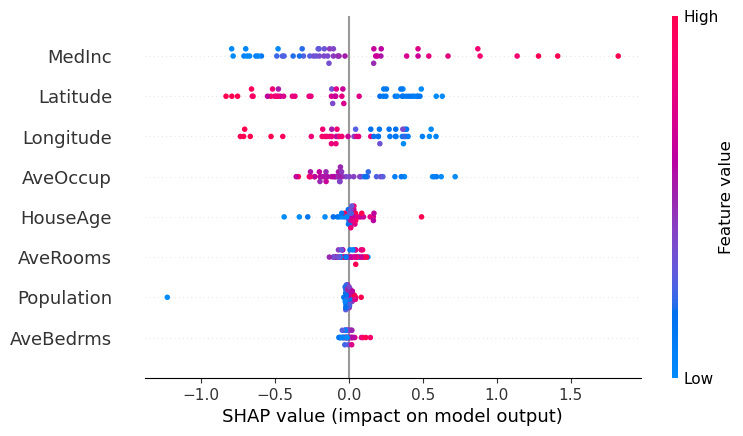

In [24]:
# Plots the beeswarm
shap.plots.beeswarm(shap_values.sample(50))

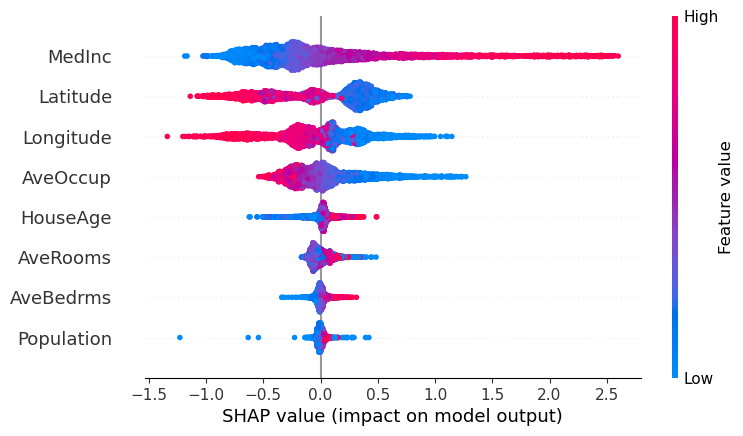

In [30]:
shap.summary_plot(shap_values)

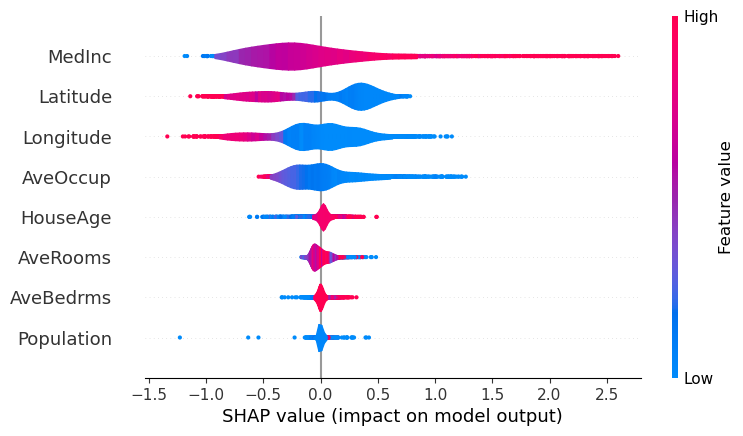

In [25]:
# Violin plot
shap.summary_plot(shap_values, plot_type='violin')

In [26]:
# Prints the SHAP feature importances
print_feature_importances_shap_values(shap_values, X_test.columns)

MedInc -> 0.4957 (softmax = 0.1663)
Latitude -> 0.3819 (softmax = 0.1484)
Longitude -> 0.2942 (softmax = 0.1359)
AveOccup -> 0.2180 (softmax = 0.1260)
HouseAge -> 0.0638 (softmax = 0.1080)
AveRooms -> 0.0615 (softmax = 0.1077)
AveBedrms -> 0.0297 (softmax = 0.1043)
Population -> 0.0208 (softmax = 0.1034)


### SHAP local evaluation
For a single example

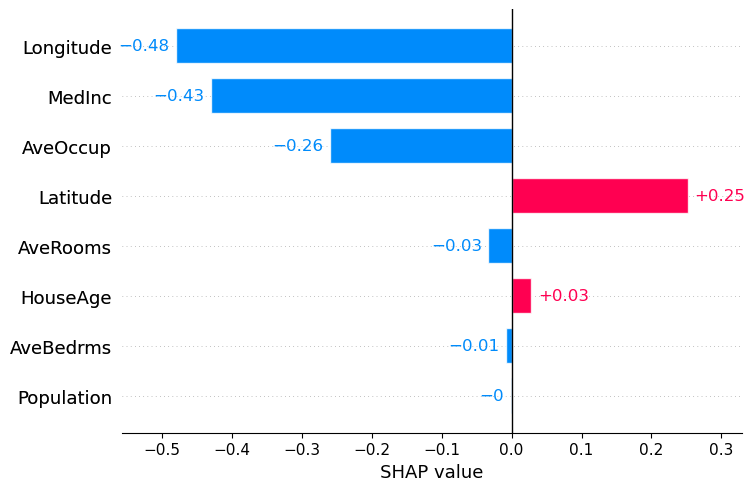

In [27]:
shap.plots.bar(shap_values[0])

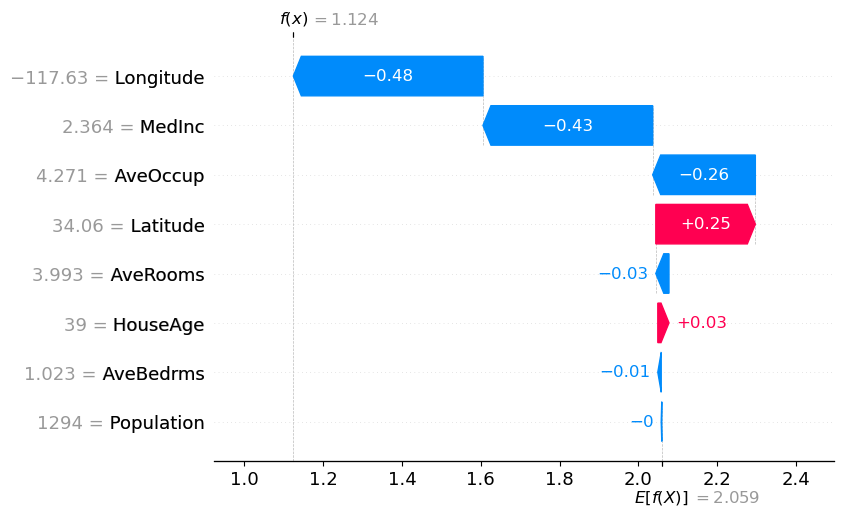

In [28]:
shap.plots.waterfall(shap_values[0], max_display=10)

In [29]:
shap.initjs()
shap.plots.force(shap_values[0])